# 04 — Model Benchmark
## HumanForYou — Employee Attrition Prediction

---

### Objective

**Systematically compare multiple classification algorithms** to identify the best candidate(s) for attrition prediction:
1. Train each model with default hyperparameters
2. Evaluate on the test set using multiple metrics (Accuracy, Precision, Recall, F1, AUC-ROC)
3. Generate comparison visualizations
4. Select top model(s) for hyperparameter tuning in the next notebook

> **Adapted from** the model benchmark methodology used in a previous computer vision project — same systematic comparison approach applied to tabular classification.

> This notebook expects preprocessed data from **03_Feature_Engineering**.

## Section 1: Setup

In [1]:
# ==============================================================================
# IMPORTS
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from pathlib import Path

# Only suppress expected warnings, not real errors
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.model_selection import cross_val_score

# Plotting config
plt.rcParams.update({"figure.figsize": (12, 6), "figure.dpi": 100})
sns.set_theme(style="whitegrid")

# --- Path Configuration ---
_cwd = Path.cwd()
if (_cwd / "data" / "raw").exists():
    PROJECT_ROOT = _cwd
elif (_cwd.parent / "data" / "raw").exists():
    PROJECT_ROOT = _cwd.parent
else:
    raise FileNotFoundError(
        "Cannot find project root: 'data/raw/' not found in CWD or parent. "
        "Run this notebook from the project root or notebooks/ directory."
    )

OUTPUT_DIR = str(PROJECT_ROOT / "outputs")

# Load preprocessed data — NON-SMOTE for fair evaluation
# Using class_weight='balanced' in models instead of SMOTE pre-applied data,
# to ensure consistency between benchmark, CV, and tuning (NB05).
X_train = pd.read_csv(f"{OUTPUT_DIR}/X_train_no_smote.csv")
X_test  = pd.read_csv(f"{OUTPUT_DIR}/X_test.csv")
y_train = pd.read_csv(f"{OUTPUT_DIR}/y_train_no_smote.csv").squeeze()
y_test  = pd.read_csv(f"{OUTPUT_DIR}/y_test.csv").squeeze()

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Train attrition rate: {y_train.mean()*100:.1f}% (real distribution, no SMOTE)")
print(f"Test  attrition rate: {y_test.mean()*100:.1f}%")

Train: (3528, 23) | Test: (882, 23)
Train attrition rate: 16.1% (real distribution, no SMOTE)
Test  attrition rate: 16.1%


## Section 2: Model Registry

Define all candidate models. Models that support `class_weight='balanced'` or `scale_pos_weight` use native class balancing instead of pre-applied SMOTE, ensuring consistent handling of class imbalance across benchmark and cross-validation.

In [2]:
# ==============================================================================
# MODEL REGISTRY — Candidates for benchmark
# ==============================================================================

# Compute class imbalance ratio for XGBoost
_scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class ratio (neg/pos): {_scale_pos:.2f} — used for scale_pos_weight")

MODELS = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"),
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight="balanced"),
    "Gradient Boosting":   GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost":             XGBClassifier(n_estimators=100, random_state=42,
                                         eval_metric="logloss", verbosity=0,
                                         scale_pos_weight=_scale_pos),
    "SVM (RBF)":           SVC(kernel="rbf", probability=True, random_state=42, class_weight="balanced"),
    "KNN":                 KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Decision Tree":       DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "AdaBoost":            AdaBoostClassifier(n_estimators=100, random_state=42),
    "MLP":                 MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
}

print(f"\nRegistered {len(MODELS)} models for benchmark.")
for name in MODELS:
    print(f"  - {name}")

Class ratio (neg/pos): 5.20 — used for scale_pos_weight

Registered 9 models for benchmark.
  - Logistic Regression
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - SVM (RBF)
  - KNN
  - Decision Tree
  - AdaBoost
  - MLP


## Section 3: Training & Evaluation Loop

Train each model on **non-SMOTE data** (with native class balancing), compute metrics on the test set, and record training time. This ensures consistency between benchmark results and cross-validation scores.

In [3]:
# ==============================================================================
# BENCHMARK LOOP — Train, predict, evaluate
# ==============================================================================

results = []

for name, model in MODELS.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    # Train
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    results.append({
        "Model": name, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1-Score": f1, "AUC-ROC": auc,
        "Train Time (s)": round(train_time, 2)
    })
    
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}" if not np.isnan(auc) else "  AUC-ROC:   N/A")
    print(f"  Time:      {train_time:.2f}s")

df_results = pd.DataFrame(results).sort_values("F1-Score", ascending=False).reset_index(drop=True)
print("\n\nBenchmark complete!")


Training: Logistic Regression
  Accuracy:  0.7574
  Precision: 0.3676
  Recall:    0.7042
  F1-Score:  0.4831
  AUC-ROC:   0.8019
  Time:      0.02s

Training: Random Forest
  Accuracy:  0.9966
  Precision: 1.0000
  Recall:    0.9789
  F1-Score:  0.9893
  AUC-ROC:   0.9922
  Time:      0.19s

Training: Gradient Boosting
  Accuracy:  0.8968
  Precision: 0.8592
  Recall:    0.4296
  F1-Score:  0.5728
  AUC-ROC:   0.9166
  Time:      0.67s

Training: XGBoost
  Accuracy:  0.9966
  Precision: 1.0000
  Recall:    0.9789
  F1-Score:  0.9893
  AUC-ROC:   0.9964
  Time:      0.23s

Training: SVM (RBF)
  Accuracy:  0.8946
  Precision: 0.6256
  Recall:    0.8592
  F1-Score:  0.7240
  AUC-ROC:   0.9406
  Time:      1.87s

Training: KNN
  Accuracy:  0.8390
  Precision: 0.5000
  Recall:    0.3732
  F1-Score:  0.4274
  AUC-ROC:   0.9131
  Time:      0.00s

Training: Decision Tree
  Accuracy:  0.9921
  Precision: 0.9927
  Recall:    0.9577
  F1-Score:  0.9749
  AUC-ROC:   0.9782
  Time:      0.03s

T

## Section 4: Results Visualization

In [4]:
# ==============================================================================
# BENCHMARK COMPARISON TABLE
# ==============================================================================

print("MODEL BENCHMARK — Sorted by F1-Score")
print("=" * 90)
display_cols = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC", "Train Time (s)"]
print(df_results[display_cols].to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Export
df_results.to_csv(f"{OUTPUT_DIR}/model_benchmark_results.csv", index=False)
print(f"\nResults saved to {OUTPUT_DIR}/model_benchmark_results.csv")

MODEL BENCHMARK — Sorted by F1-Score
              Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  Train Time (s)
      Random Forest    0.9966     1.0000  0.9789    0.9893   0.9922          0.1900
            XGBoost    0.9966     1.0000  0.9789    0.9893   0.9964          0.2300
                MLP    0.9955     0.9929  0.9789    0.9858   0.9911          1.8200
      Decision Tree    0.9921     0.9927  0.9577    0.9749   0.9782          0.0300
          SVM (RBF)    0.8946     0.6256  0.8592    0.7240   0.9406          1.8700
  Gradient Boosting    0.8968     0.8592  0.4296    0.5728   0.9166          0.6700
Logistic Regression    0.7574     0.3676  0.7042    0.4831   0.8019          0.0200
                KNN    0.8390     0.5000  0.3732    0.4274   0.9131          0.0000
           AdaBoost    0.8685     0.7600  0.2676    0.3958   0.8259          0.3500

Results saved to C:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou\outputs/model_benchmark_results.csv


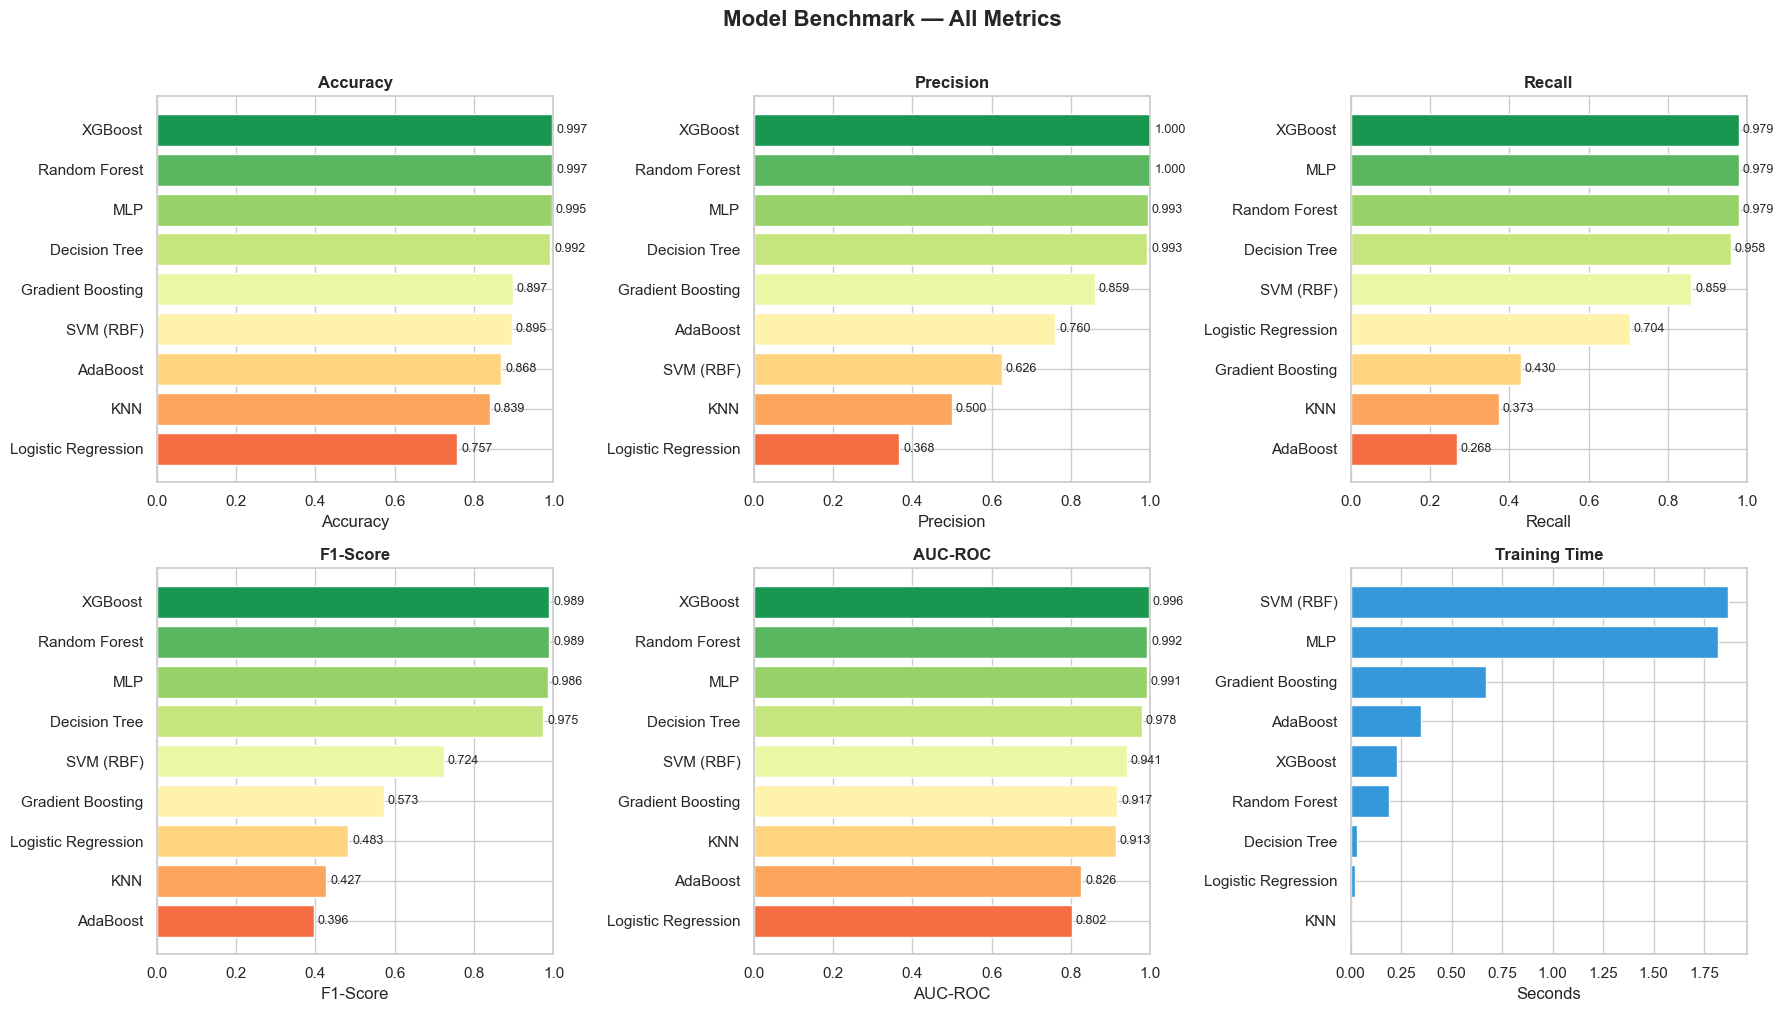

In [5]:
# ==============================================================================
# METRIC COMPARISON BAR CHARTS
# ==============================================================================

metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    df_sorted = df_results.sort_values(metric, ascending=True)
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(df_sorted)))
    axes[i].barh(df_sorted["Model"], df_sorted[metric], color=colors)
    axes[i].set_xlabel(metric)
    axes[i].set_title(metric, fontweight="bold")
    axes[i].set_xlim(0, 1)
    # Annotate values
    for j, (val, model) in enumerate(zip(df_sorted[metric], df_sorted["Model"])):
        if not np.isnan(val):
            axes[i].text(val + 0.01, j, f"{val:.3f}", va="center", fontsize=9)

# Training time
df_sorted = df_results.sort_values("Train Time (s)", ascending=True)
axes[5].barh(df_sorted["Model"], df_sorted["Train Time (s)"], color="#3498db")
axes[5].set_xlabel("Seconds")
axes[5].set_title("Training Time", fontweight="bold")

plt.suptitle("Model Benchmark — All Metrics", fontsize=16, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/benchmark_comparison.png", bbox_inches="tight")
plt.show()

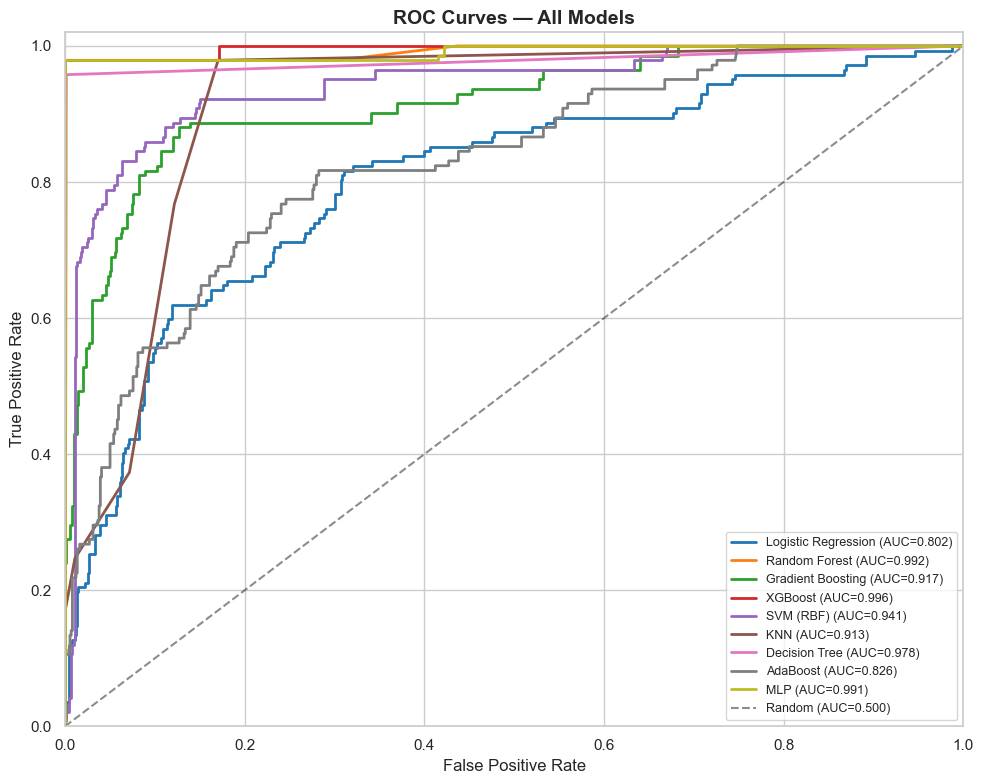

In [6]:
# ==============================================================================
# ROC CURVES — All models
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10

for i, (name, model) in enumerate(MODELS.items()):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_val = roc_auc_score(y_test, y_proba)
        ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})", color=cmap(i), linewidth=2)

ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Random (AUC=0.500)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves — All Models", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=9)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/benchmark_roc_curves.png", bbox_inches="tight")
plt.show()

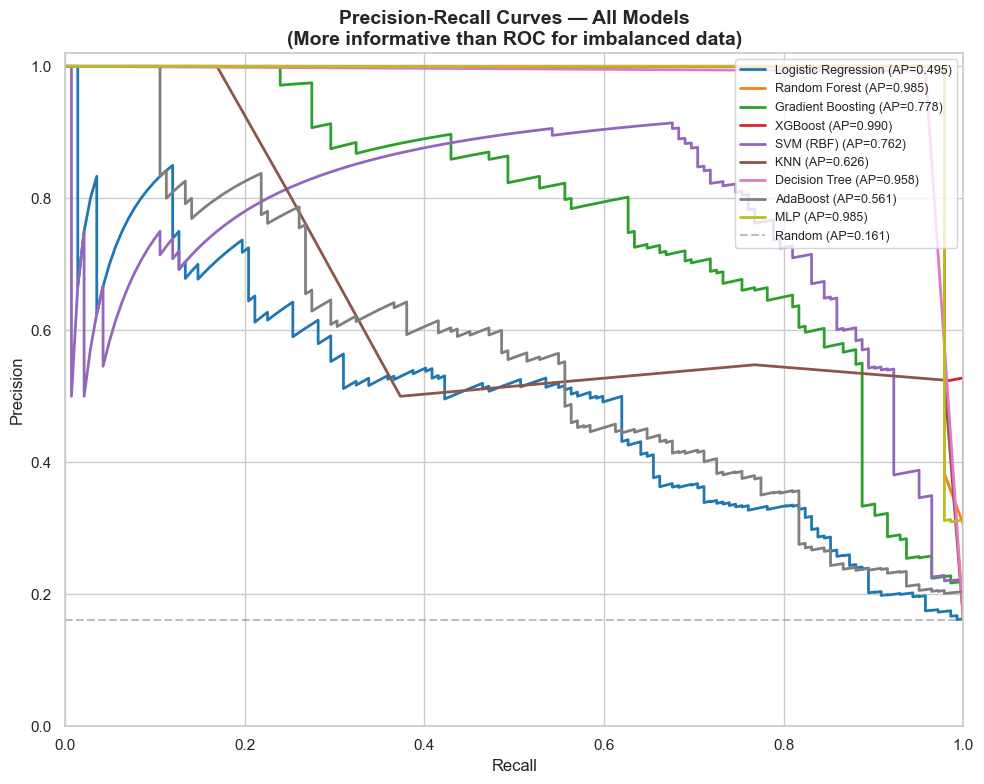

In [7]:
# ==============================================================================
# PRECISION-RECALL CURVES — All models (more informative for imbalanced data)
# ==============================================================================

from sklearn.metrics import average_precision_score

fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10

for i, (name, model) in enumerate(MODELS.items()):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        ax.plot(rec_curve, prec_curve, label=f"{name} (AP={ap:.3f})", color=cmap(i), linewidth=2)

# Baseline = prevalence of positive class
baseline = y_test.mean()
ax.axhline(baseline, color="gray", linestyle="--", alpha=0.5, label=f"Random (AP={baseline:.3f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curves — All Models\n(More informative than ROC for imbalanced data)",
             fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=9)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/benchmark_pr_curves.png", bbox_inches="tight")
plt.show()

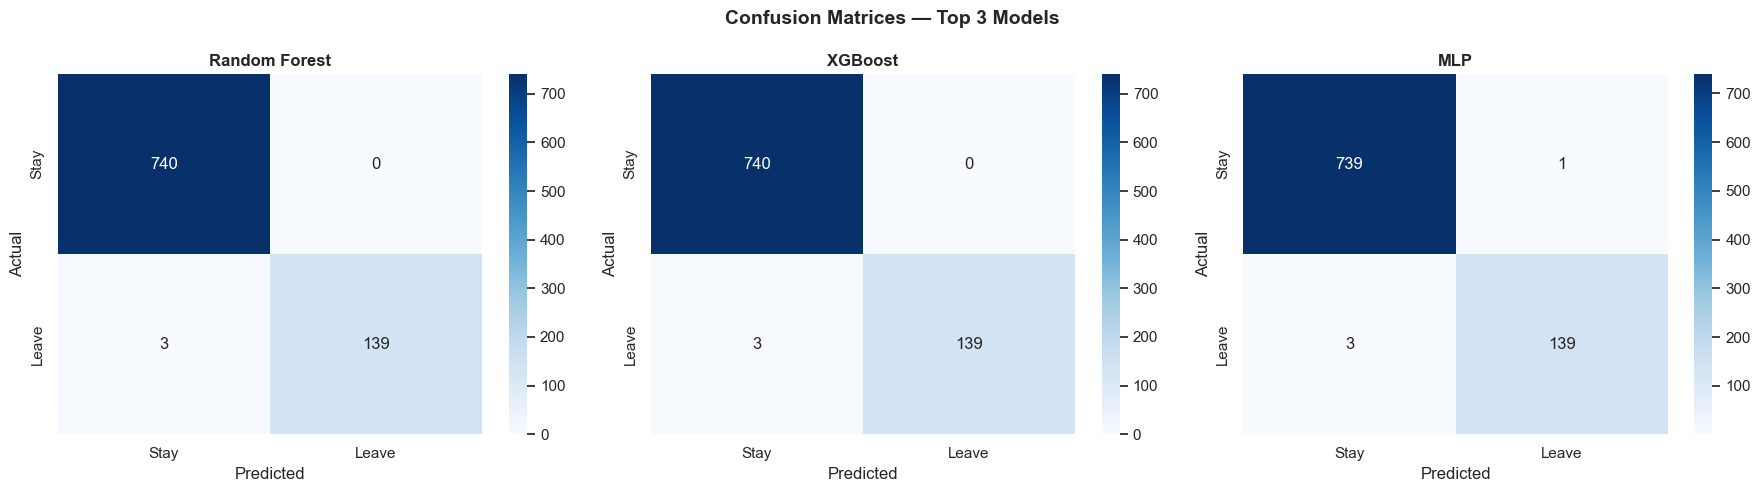

In [8]:
# ==============================================================================
# CONFUSION MATRICES — Top 3 models
# ==============================================================================

top3 = df_results.head(3)["Model"].tolist()
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(top3):
    model = MODELS[name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i],
                xticklabels=["Stay", "Leave"], yticklabels=["Stay", "Leave"])
    axes[i].set_title(f"{name}", fontweight="bold")
    axes[i].set_ylabel("Actual")
    axes[i].set_xlabel("Predicted")

plt.suptitle("Confusion Matrices — Top 3 Models", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/benchmark_confusion_matrices.png", bbox_inches="tight")
plt.show()

## Section 5: Cross-Validation Stability Check

5-FOLD CROSS-VALIDATION — Top 3 Models
  Random Forest             F1 = 0.9423 ± 0.0187  [np.float64(0.9589), np.float64(0.9151), np.float64(0.9245), np.float64(0.9585), np.float64(0.9545)]
  XGBoost                   F1 = 0.9424 ± 0.0280  [np.float64(0.9515), np.float64(0.9182), np.float64(0.9132), np.float64(0.9911), np.float64(0.9381)]
  MLP                       F1 = 0.9275 ± 0.0231  [np.float64(0.9251), np.float64(0.8889), np.float64(0.9209), np.float64(0.9511), np.float64(0.9515)]


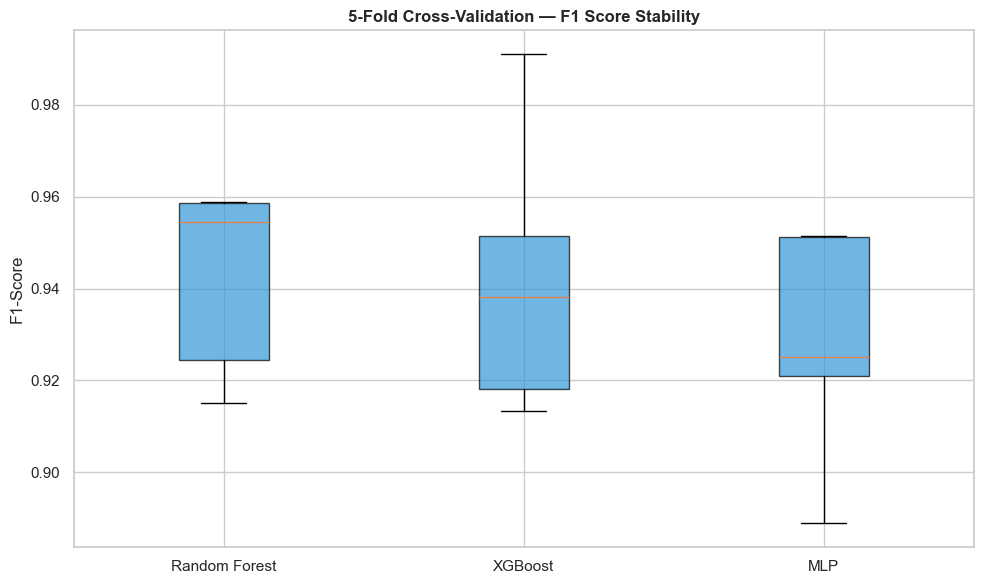

In [9]:
# ==============================================================================
# CROSS-VALIDATION — Top 3 models
# ==============================================================================

print("5-FOLD CROSS-VALIDATION — Top 3 Models")
print("=" * 65)

# X_train / y_train are already non-SMOTE data (loaded in Section 1)
# CV and benchmark are now fully consistent.

cv_results = {}
for name in top3:
    model = MODELS[name].__class__(**MODELS[name].get_params())  # fresh copy
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1)
    cv_results[name] = scores
    print(f"  {name:25s} F1 = {scores.mean():.4f} ± {scores.std():.4f}  {list(scores.round(4))}")

# Box plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True,
           boxprops=dict(facecolor="#3498db", alpha=0.7))
ax.set_ylabel("F1-Score")
ax.set_title("5-Fold Cross-Validation — F1 Score Stability", fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/benchmark_cv_stability.png", bbox_inches="tight")
plt.show()

## Section 6: Model Selection Recommendation

In [10]:
# ==============================================================================
# RECOMMENDATION
# ==============================================================================

print("=" * 65)
print("MODEL SELECTION RECOMMENDATION")
print("=" * 65)

best_model = df_results.iloc[0]["Model"]
best_f1    = df_results.iloc[0]["F1-Score"]
best_auc   = df_results.iloc[0]["AUC-ROC"]

print(f"""
Best model by F1-Score: {best_model}
  → F1 = {best_f1:.4f}, AUC-ROC = {best_auc:.4f}

Top 3 candidates for hyperparameter tuning:
{chr(10).join(f"  {i+1}. {row['Model']} (F1={row['F1-Score']:.4f})" for i, (_, row) in enumerate(df_results.head(3).iterrows()))}

Context-specific considerations for HumanForYou:
  • RECALL is critical: a missed at-risk employee = lost talent
  • PRECISION matters: false alerts waste HR resources
  • F1-Score balances both — primary selection metric
  • AUC-ROC measures overall ranking quality

→ Proceed to 05_Model_Optimization.ipynb with top candidates.
""")

MODEL SELECTION RECOMMENDATION

Best model by F1-Score: Random Forest
  → F1 = 0.9893, AUC-ROC = 0.9922

Top 3 candidates for hyperparameter tuning:
  1. Random Forest (F1=0.9893)
  2. XGBoost (F1=0.9893)
  3. MLP (F1=0.9858)

Context-specific considerations for HumanForYou:
  • RECALL is critical: a missed at-risk employee = lost talent
  • PRECISION matters: false alerts waste HR resources
  • F1-Score balances both — primary selection metric
  • AUC-ROC measures overall ranking quality

→ Proceed to 05_Model_Optimization.ipynb with top candidates.

